In [1]:
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.backends.backend_pdf import PdfPages
import random
import pingouin
import os

#plots.py
# . . .
def plot_lines(df, linewidth = 1, figsize = (40,20),
               secondary_y = None, legend=True,
               h_zero = True, pp = None, 
               save_fig = False):
    
    fig, ax = plt.subplots(figsize = figsize)    
    # If no secondary_y (axis), plot all variables at once
    df.dropna().plot.line(linewidth = linewidth, ax = ax, secondary_y=secondary_y, legend = legend)
    # Turn the text on the x-axis so that it reads vertically
    ax.tick_params(axis='x', rotation=90)
    # Get rid of tick lines perpendicular to the axis for aesthetic
    ax.tick_params('both', length=0, which='both')
    # transform y-axis values from sci notation to integers
    vals = ax.get_yticks()
    ax.set_yticklabels([round(x,2) for x in vals]) 
    if h_zero: ax.axhline(0, ls="--", color = "k")
    
    # format image filename 
    remove_chars = "[]:$'\\"
    filename = str(list(df.keys()))
    for char in remove_chars:
        filename = filename.replace(char, "")  
    if save_fig:
        try:
            os.mkdir("plots")
        except:
            pass
        plt.savefig("plots/" + filename[:50] + " line.png", 
                bbox_inches = "tight")
    #[:50] + " line.png"
    # save image if PdfPages object was passed
    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def plot_scatter(data, s = 75, figsize = (40, 20), save_fig = False, pp = None):
    # Create plot for every unique pair of variables
    df = data.copy()
    for var1 in df:
        for var2 in df:
            if var1 != var2:
                fig, ax = plt.subplots(figsize = figsize)
                # Create list of years from index
                # Year will be represented by color
                if "Year" not in df.keys():
                    df["Year"] = [int(str(ind)[:4]) for ind in df.index] 
                df.plot.scatter(x = var1, y = var2, s = s, ax = ax, 
                                c = "Year", cmap = "viridis")
                # Turn the text on the x-axis so that it reads vertically
                ax.tick_params(axis='x', rotation=90)
                # Get rid of tick lines perpendicular to the axis for aesthetic
                ax.tick_params('both', length=0, which='both')
                # save image if PdfPages object was passed
                if save_fig:
                    try:
                        os.mkdir("plots")
                    except:
                        pass
                    plt.savefig("plots/" + str(list(df.keys())).replace("[", "").replace("]","")[:40] + " scatter.png",
                            bbox_inches = "tight")
                    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def corr_matrix_heatmap(df, save_fig = False, pp = None):  
    #Create a figure to visualize a corr matrix  
    fig, ax = plt.subplots(figsize=(20,20))  
    # use ax.imshow() to create a heatmap of correlation values  
    # seismic mapping shows negative values as blue and positive values as red  
    im = ax.imshow(df, norm = plt.cm.colors.Normalize(-1,1), cmap = "seismic")  
    # create a list of labels, stacking each word in a label by replacing " "  
    # with "\n"  
    labels = df.keys()  
    num_vars = len(labels)  
    tick_labels = [lab.replace(" ", "\n") for lab in labels]  
    # adjust font size according to the number of variables visualized  
    tick_font_size = 120 / num_vars  
    val_font_size = 200 / num_vars  
    plt.rcParams.update({'font.size': tick_font_size}) 
    # prepare space for label of each column  
    x_ticks = np.arange(num_vars)  
    # select labels and rotate them 90 degrees so that they are vertical  
    plt.xticks(x_ticks, tick_labels, fontsize = tick_font_size, rotation = 90)  
    # prepare space for label of each row  
    y_ticks = np.arange(len(labels))  
    # select labels  
    plt.yticks(y_ticks, tick_labels, fontsize = tick_font_size)  
    # show values in each tile of the heatmap  
    for i in range(len(labels)):  
        for j in range(len(labels)):  
            text = ax.text(i, j, str(round(df.values[i][j],2)),  
                           fontsize= val_font_size, ha="center",   
                           va="center", color = "w")  
    #Create title with Times New Roman Font  
    title_font = {"fontname":"Times New Roman"}  
    plt.title("Correlation", fontsize = 50, **title_font)  
    #Call scale to show value of colors 
    cbar = fig.colorbar(im)
    plt.show()
    if save_fig:
        try:
            os.mkdir("plots")
        except:
            pass
        plt.savefig("plots/" + str(list(df.keys())).replace("[", "").replace("]","")[:40] + " corrMatrix.png",
            bbox_inches = "tight")

        if pp != None: pp.savefig(fig, bbox_inches="tight")
    plt.close()

def plot_stacked_lines(df, plot_vars, linewidth = 1, 
                       figsize = (40, 20),
                       pp = None, total_var = False,
                      title = False):
    fig, ax = plt.subplots(figsize = figsize)
    # df.plot.area() created a stacked plot
    df[plot_vars].plot.area(stacked = True, linewidth = linewidth,
                            ax = ax)
    if total_var != False:
        df[total_var].plot.line(linewidth = linewidth, ax = ax,
                                c = "k",label = total_var, 
                                ls = "--")
    # place legend in top left corner of plot
    # format legend so that there are two columns of names
    ax.legend(loc = 2, ncol = 2)
    if title != False:
        plt.title(title)
        
def gather_data(data_codes, start, end = datetime.datetime.today(), freq = "A"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()
            
    return df

In [2]:

data_dict = {
             "PPI: All Comodities": "PPIACO",
             "PPI: Lumber and Wood Products":"WPU081",
            "PPI: Copper and Copper Products":"WPUSI019011",
            "PPI: Gas and Oil Extraction":"PCU21112111",
            "PPI: Final Demand": "PPIFIS",
            "Expected Inflation: 5 Year Breakeven Rate":"T5YIE",
            "$CPI$":"CPIAUCNS",             
             "$CPI_{Core}$":"CPILFESL",
            "$PCEPI_{Core}$":"PCEPILFE",
            "$PCEPI$": "PCEPI",
            "Industrial Production Index":"INDPRO",
            "$\pi_{e_{5Y}}$":"T5YIE",
             "$\pi_{e_{10Y}}$":"T10YIE",
             "Currency in Circulation":"WCURCIR",
             "M2":"WM2NS",
#             "Personal Savings Rate":"PSAVERT",
#             "Private Weekly Employee Earnings":"CES0500000011",
#             "Private Hourly Nonsupervisory Earnings":"AHETPI",
            "Unemployment Rate":"UNRATE",
            "Business Inventories":"BUSINV"}
freq = "M"
start = datetime.datetime(1990, 1, 1)
# end = datetime.datetime(1985, 12, 31)
end =datetime.datetime.today()

df = gather_data(data_dict, start, 
          end = end, freq = freq)

C:\Users\JLCat\AppData\Roaming\Python\Python39\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\JLCat\AppData\Roaming\Python\Python39\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
for key in df:
    if "Earnings" in key or "Inventories" in key:
        df["Real " + key ] = df[key].div(df["$CPI_{Core}$"])


In [4]:
keys = df.keys()
annual_rate = df.copy()
monthly_rate = df.copy()
for key in keys:
#     if "PPI" in key or "CPI" in key or "M2" in key:
    annual_rate[key ] = df[key].pct_change(12) * 100
    monthly_rate[key] = ((df[key].pct_change(1)).add(1)).pow(12).sub(1).mul(100)
# annual_rate.rename(columns = {"$CPI_{Core}$":"$\pi_{CPI_{Core}}$",
#                               "$PCE_{Core}$":"$\pi_{PCE_{Core}}$",                              
#                      "$CPI_{Urban}$":"$\pi_{CPI_{Urban}}$",
#                     "PPI: All Comodities":"$\pi_{PPI_{Commodities}}$",
#                     "PPI: Final Demand": "$\pi_{PPI_{Final Demand}}$"}, inplace = True)
# monthly_rate.rename(columns = {"$CPI_{Core}$":"$\pi_{CPI_{Core}}$",
#                               "$PCE_{Core}$":"$\pi_{PCE_{Core}}$",
#                      "$CPI_{Urban}$":"$\pi_{CPI_{Urban}}$",
#                     "PPI: All Comodities":"$\pi_{PPI_{Commodities}}$",
#                     "PPI: Final Demand": "$\pi_{PPI_{Final Demand}}$"}, inplace = True)

for key in keys:
    if "Rate" in key:
        annual_rate[key] = df[key]
        monthly_rate[key] = df[key]
        
diff_annual_rate = annual_rate.diff(12)

In [5]:
# set default fontsize for text in plot
plt.rcParams.update({'font.size': 42})
plot_keys = ["PPI: Lumber and Wood Products",
             "PPI: Copper and Copper Products",
             "PPI: Gas and Oil Extraction"]
plot_df = annual_rate[plot_keys]
plot_df

,PPI: Lumber and Wood Products,PPI: Copper and Copper Products,PPI: Gas and Oil Extraction
DATE,,,
1990-01-31,NaN,NaN,NaN
1990-02-28,NaN,NaN,NaN
1990-03-31,NaN,NaN,NaN
1990-04-30,NaN,NaN,NaN
1990-05-31,NaN,NaN,NaN
...,...,...,...
2022-08-31,8.498200,-10.395837,74.445783
2022-09-30,6.100320,-10.028897,47.046489
2022-10-31,-1.865450,-12.071623,-1.136133


C:\Users\JLCat\AppData\Local\Temp\ipykernel_22956\2410257932.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x,2) for x in vals])


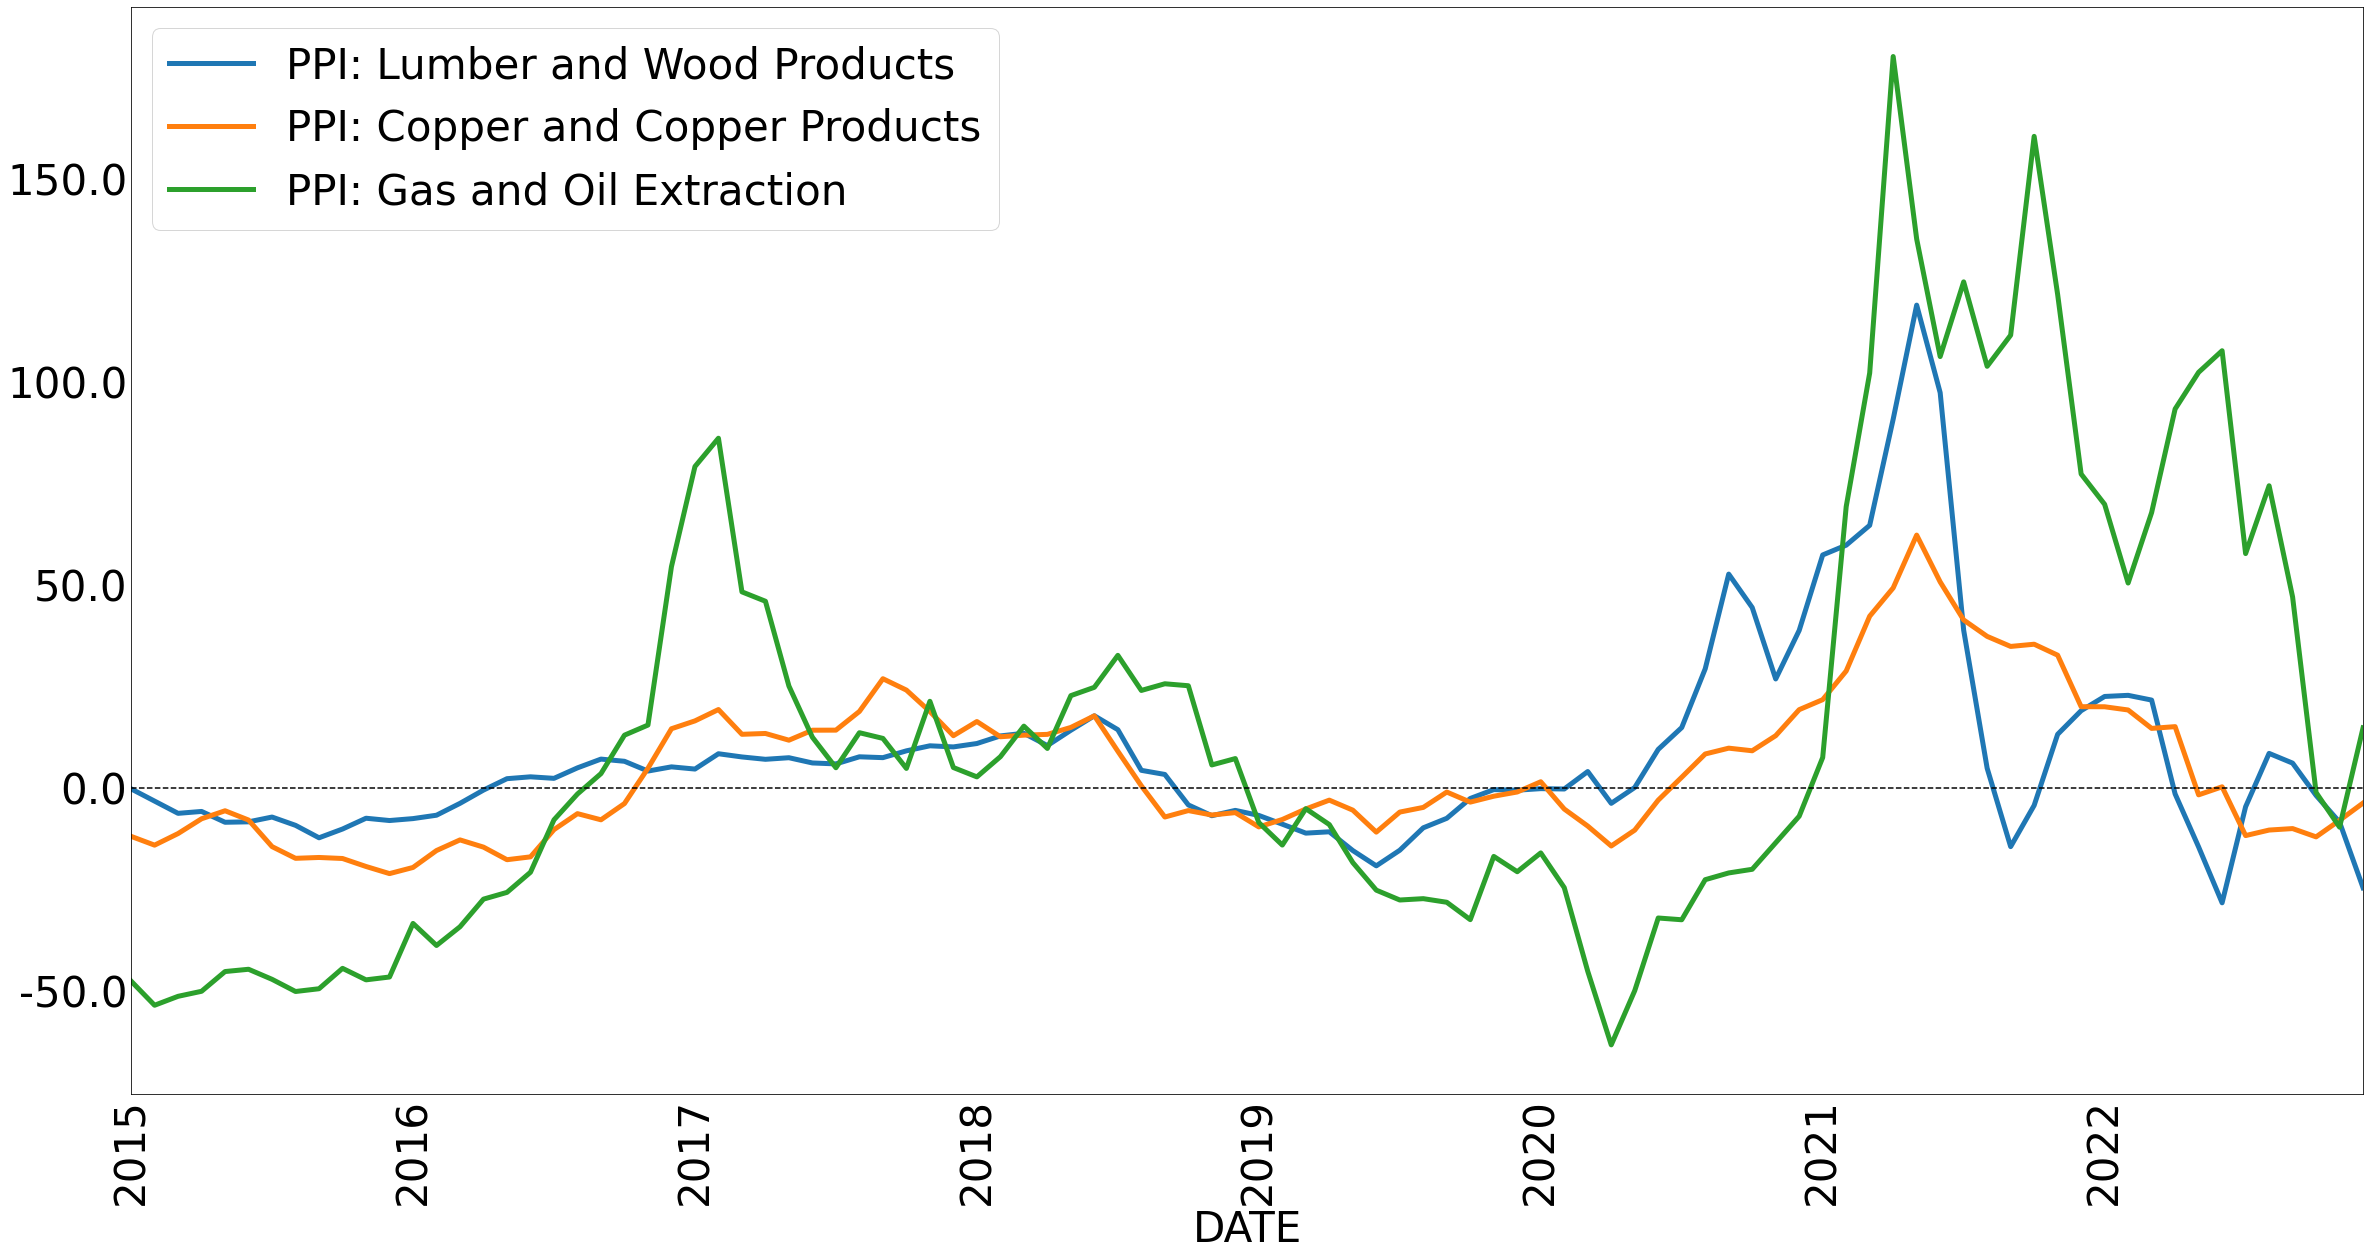

In [6]:
plot_lines(plot_df.loc["2015":], linewidth = 5)
plot_df.to_csv("PPIData.csv")

C:\Users\JLCat\AppData\Local\Temp\ipykernel_22956\2410257932.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x,2) for x in vals])


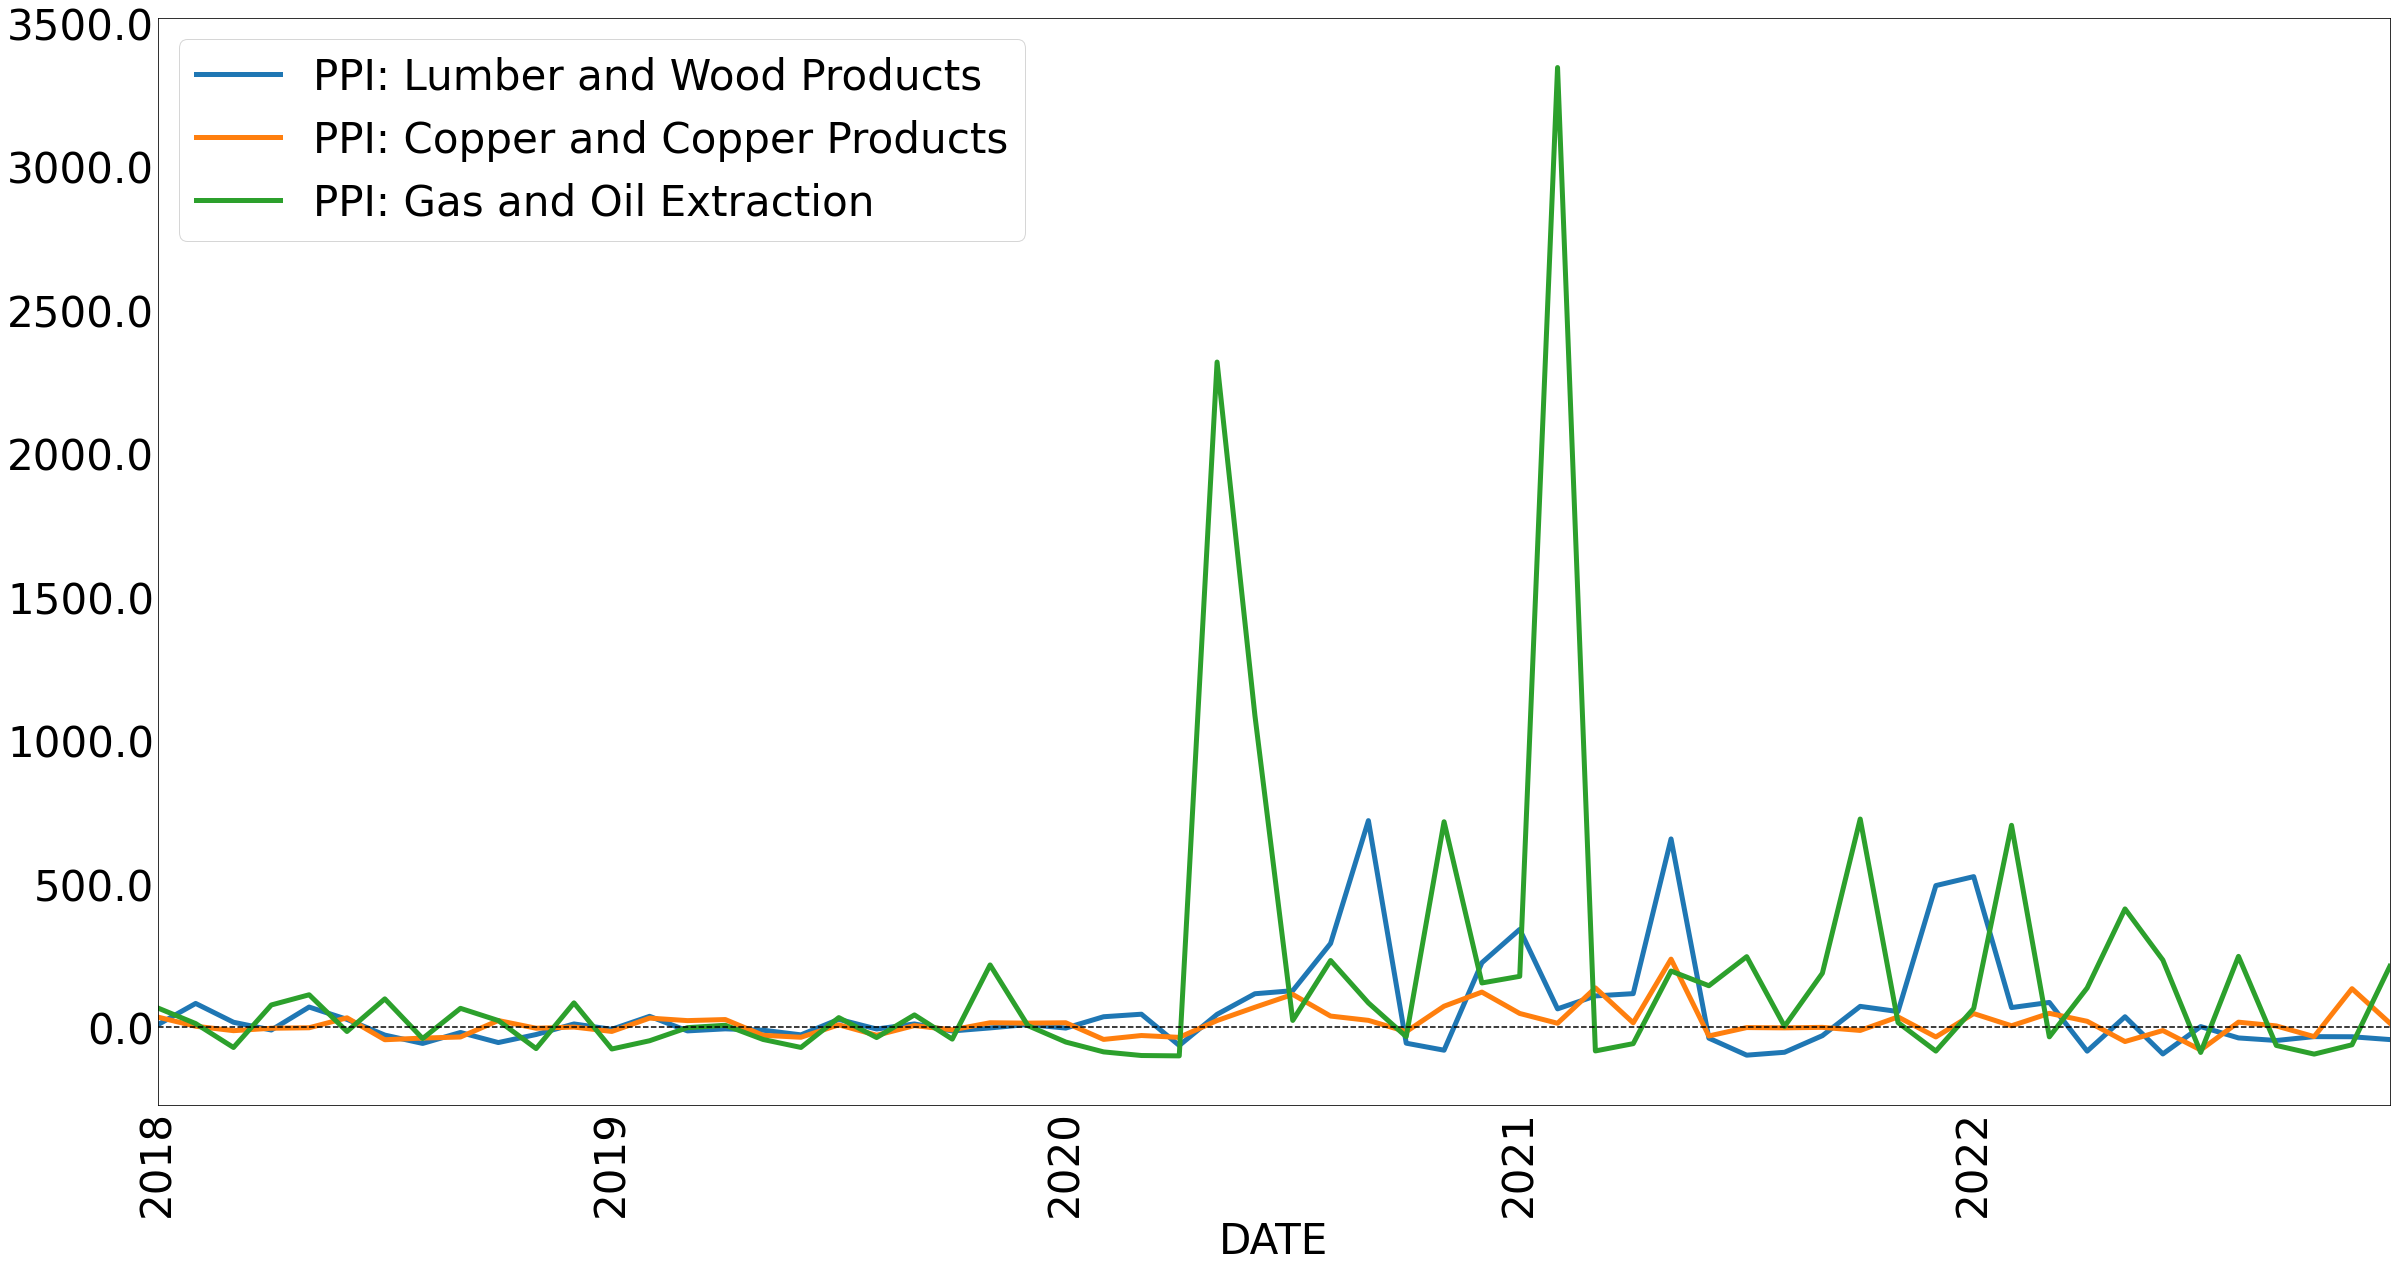

In [7]:
plot_df = monthly_rate[plot_keys]
plot_lines(plot_df.loc["2018":], linewidth = 5)

C:\Users\JLCat\AppData\Local\Temp\ipykernel_22956\1021273081.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(str(y) + "%" for y in ax.get_yticks())


Text(0.5, 0, '')

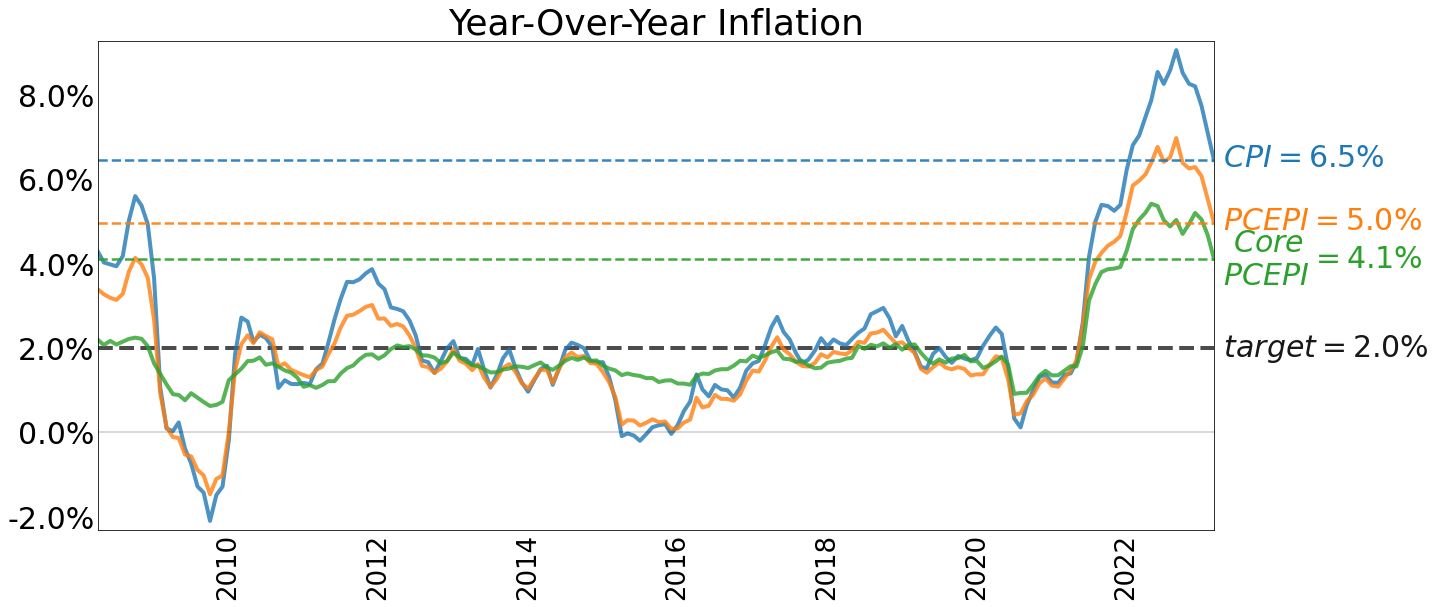

In [8]:
plt.rcParams['axes.ymargin'] = 0.02
plt.rcParams['axes.xmargin'] = 0.00

plt.rcParams.update({'font.size': 30})
plot_keys = ["$CPI$", 
             "$PCEPI$",
             "$PCEPI_{Core}$",
            ]            
#             "$\pi_{PPI_{Final Demand}}$"]
plot_df = annual_rate[plot_keys].loc["2008":]#.dropna()
dates = list(plot_df.index)

fig,ax = plt.subplots(figsize=(20,10))
ax.axhline(2, ls = "--", linewidth = 4, color = "k", alpha = .7)
plot_df[plot_keys[:]].plot(ax = ax, linewidth = 4, legend = False, alpha = .8)
# plot_df[plot_keys[1:]].iloc[:-1].plot(ax = ax, linewidth = 4, color = ["C1", "C2"], legend = False, alpha = .8)


ax.axhline(0, ls = "-", color = "k", alpha = .2)

ax.axhline(plot_df[plot_keys[0]].iloc[-1], ls = "--", linewidth = 2.5, color = "C" + str(0), alpha = .9)
ax.axhline(plot_df[plot_keys[1]].iloc[-1], ls = "--", linewidth = 2.5, color = "C" + str(1), alpha = .9)
ax.axhline(plot_df[plot_keys[2]].iloc[-1], ls = "--", linewidth = 2.5, color = "C" + str(2), alpha = .9)

# ax.axhline(5, ls = "--", color = "k", alpha = .5)
ax.set_yticklabels(str(y) + "%" for y in ax.get_yticks())
plt.xticks(rotation=90, fontsize =26)
ax.tick_params('both', length=0, which='both')
# ax.text("2009-10",3 ,  plot_keys[0], color = "C0", alpha = 1)
# ax.text("2015-08",2.5 ,  plot_keys[1], color = "C1", alpha = 1)
ax.text(dates[-1], 2, " " + "$target=2.0\%$", color = "k", alpha = .9, 
        ha = "left", va = "center")
pce_core_today =  plot_df[plot_keys[2]].round(1).iloc[-1]
cpi_core_today = plot_df[plot_keys[1]].round(1).iloc[-1]
ppi_today = plot_df[plot_keys[0]].round(1).iloc[-1]

ax.text(dates[-1],pce_core_today , "  $Core$\n $PCEPI$", color = "C2", alpha = 1, 
        ha = "left", va = "center")
ax.text(dates[-1],pce_core_today , "          $=" + str(pce_core_today) +"\%$", color = "C2", alpha = 1, 
        ha = "left", va = "center")
ax.text(dates[-1],cpi_core_today , " " + plot_keys[1] + "$=" + str(cpi_core_today) +"\%$", color = "C1", alpha = 1, 
        ha = "left", va = "center")
ax.text(dates[-1], ppi_today, " " + "$CPI=" + str(ppi_today) +"\%$", color = "C0", alpha = 1,
        ha = "left", va = "center")



ax.set_title("Year-Over-Year Inflation")
plt.xticks(rotation = 90)
ax.set_xlabel("")
# plot_lines(plot_df, linewidth = 5)

#plot_df.to_csv("inflationData.csv")

In [9]:
plot_keys = ["$CPI$", 
             "$PCEPI$",
             "$PCEPI_{Core}$",
            ]            
#             "$\pi_{PPI_{Final Demand}}$"]
plot_df = annual_rate[plot_keys].loc["2008":]#.dropna()
plot_df

,$CPI$,$PCEPI$,$PCEPI_{Core}$
DATE,,,
2008-01-31,4.280294,3.388403,2.193131
2008-02-29,4.026555,3.272984,2.072026
2008-03-31,3.981456,3.190588,2.168811
2008-04-30,3.936890,3.140303,2.083266
2008-05-31,4.175543,3.282278,2.149081
...,...,...,...
2022-08-31,8.262693,6.255367,4.934052
2022-09-30,8.201670,6.288953,5.201526
2022-10-31,7.745427,6.075980,5.048390


In [10]:
plot_df = annual_rate[plot_keys].dropna().loc["2000":]


C:\Users\JLCat\AppData\Local\Temp\ipykernel_22956\994639050.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(val)) + "%" for val in ax.get_yticks()], fontsize = 26)


,$PCEPI$,$PCEPI_{Core}$
$PCEPI$,1.000000,0.825635
$PCEPI_{Core}$,0.825635,1.000000


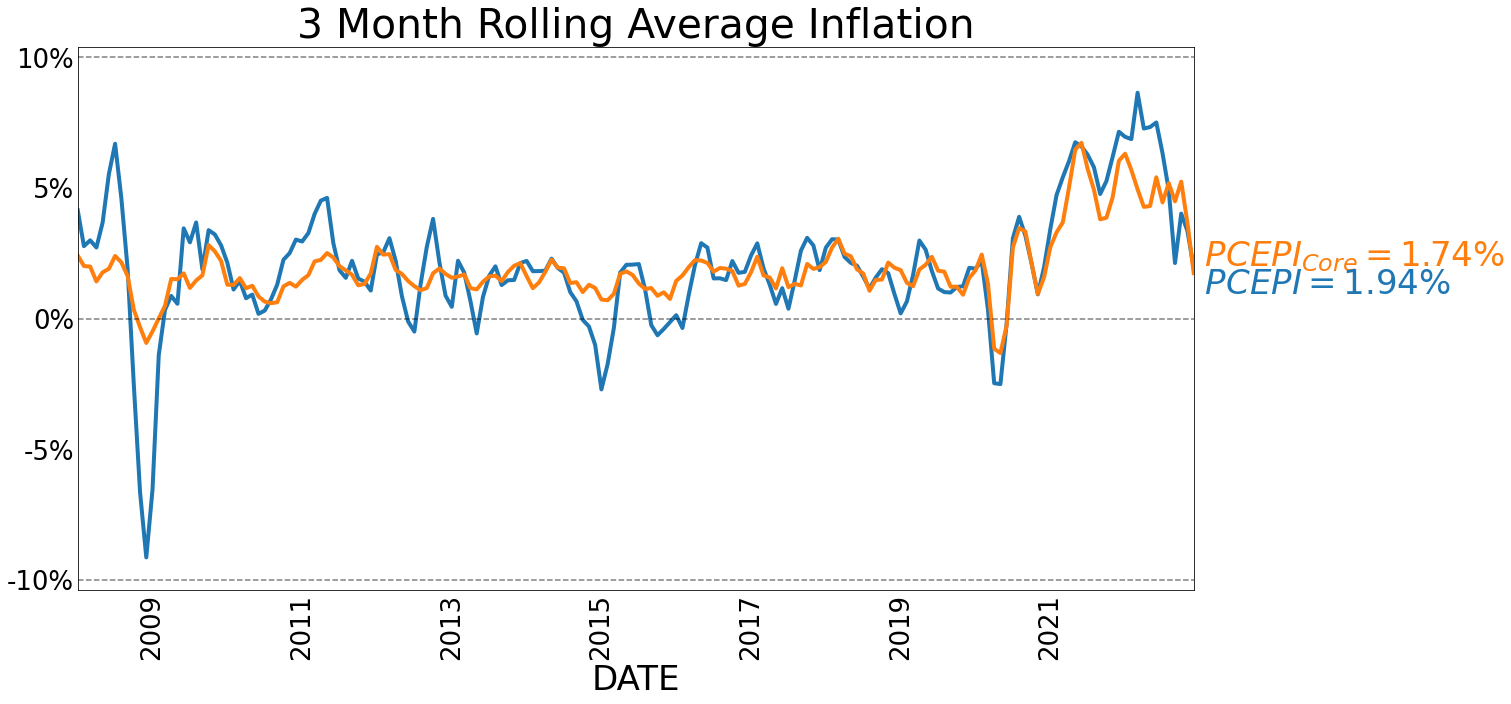

In [11]:
plt.rcParams.update({'font.size': 34})

months = 3
plot_df = monthly_rate[plot_keys].rolling(months).mean().loc["2008":].dropna()[plot_keys[1:]].iloc[:]
fig,ax = plt.subplots(figsize=(20,10))
plot_df.plot(ax = ax, linewidth = 4, legend = False)
ax.axhline(0, ls = "--", color = "k", alpha = .5)
ax.axhline(-10, ls = "--", color = "k", alpha = .5)
ax.axhline(10, ls = "--", color = "k", alpha = .5)
ax.set_yticklabels([str(int(val)) + "%" for val in ax.get_yticks()], fontsize = 26)
plt.xticks(rotation=90, fontsize =26)
ax.tick_params('both', length=0, which='both')

ax.text(dates[-1],plot_df[plot_keys[2]][-1] , " " + plot_keys[2] + "$=" + str(plot_df[plot_keys[2]].round(2)[-1]) +"\%$", color = "C1", alpha = 1, 
        ha = "left", va = "bottom")
ax.text(dates[-1],plot_df[plot_keys[1]][-1] , " " + plot_keys[1] + "$=" + str(plot_df[plot_keys[1]].round(2)[-1]) +"\%$", color = "C0", alpha = 1, 
        ha = "left", va = "top")
ax.set_title(str(months) + " Month Rolling Average Inflation")
plot_df.corr()

In [12]:
monthly_rate[plot_keys]

,$CPI$,$PCEPI$,$PCEPI_{Core}$
DATE,,,
1990-01-31,NaN,NaN,NaN
1990-02-28,5.800203,5.419193,5.998168
1990-03-31,6.763531,4.608154,5.909054
1990-04-30,1.880823,2.546624,3.641316
1990-05-31,2.828892,2.737630,3.726434
...,...,...,...
2022-08-31,-0.424451,3.266795,6.809184
2022-09-30,2.611692,4.210788,5.717367
2022-10-31,4.977879,4.568026,3.185041


C:\Users\JLCat\AppData\Local\Temp\ipykernel_22956\1650181770.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([val * 100 / 1000 for val in ax.get_yticks()], fontsize = 26)


Text(0.5, 1.0, 'Real Business Inventories')

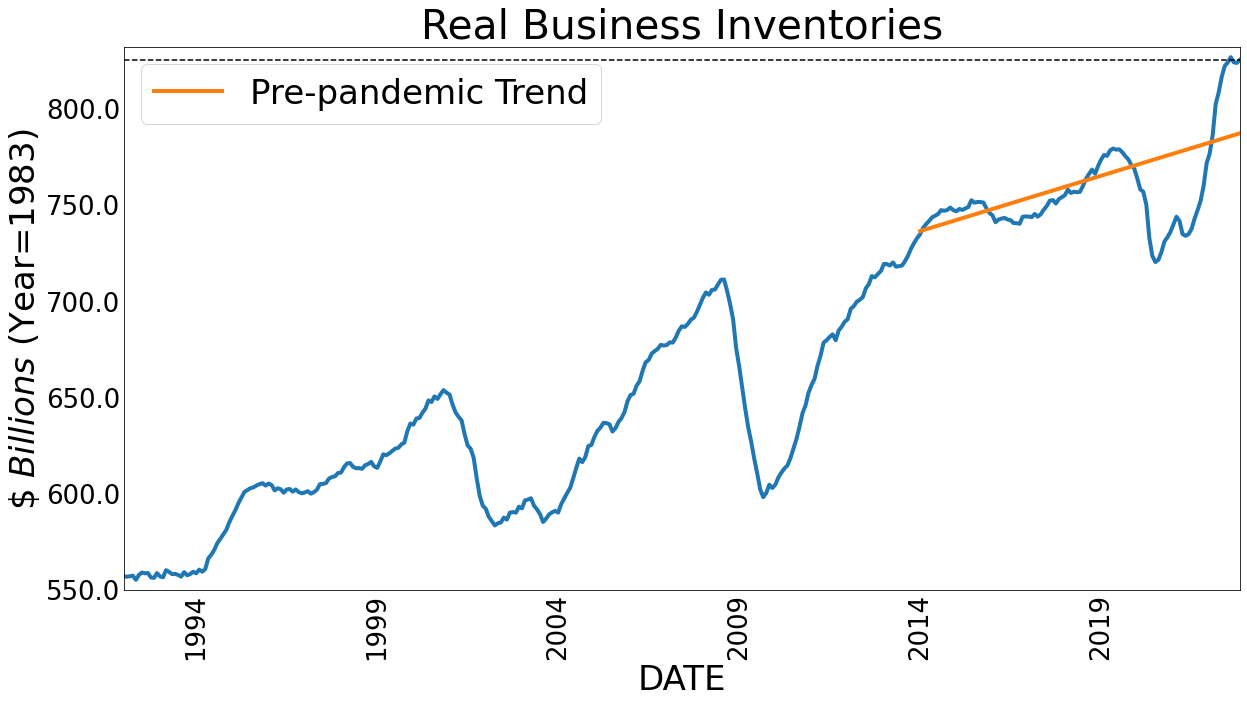

In [13]:
import statsmodels.api as sm
plt.rcParams.update({'font.size': 34})
plot_keys = ["Real Business Inventories"]
plot_df = df[plot_keys].dropna()#.loc["2008":]

fig,ax = plt.subplots(figsize=(20,10))
plot_df.plot(ax = ax, linewidth = 4, legend = False)
plot_df["Time"] = np.arange(len(plot_df))
y = plot_df[plot_keys].loc["2014":"2019"]
X = plot_df[["Time"]].loc["2014":"2019"]
X["Constant"] = 1
reg = sm.OLS(y, X)
results = reg.fit()
# plot_df["Trend"] = 
print()
X_new = plot_df[["Time"]].loc["2014":]
X_new["Intercept"] = 1
X_new["Pre-pandemic Trend"] = results.predict(X_new)
# = results.fittedvalues
X_new["Pre-pandemic Trend"].plot(ax = ax, linewidth = 4, legend = True)

ax.axhline(plot_df.iloc[-1]["Real Business Inventories"], ls = "--", color = "k")
ax.set_yticklabels([val * 100 / 1000 for val in ax.get_yticks()], fontsize = 26)
ax.set_ylabel("$\$$ $Billions$ (Year=1983)")
plt.xticks(rotation=90, fontsize =26)
ax.tick_params('both', length=0, which='both')
ax.set_title("Real Business Inventories")
# ax.text(460,18 ,  plot_keys[0], color = "C0", alpha = 1)
# ax.text(532,3 ,  plot_keys[1], color = "C1", alpha = 1)


# plot_lines(plot_df, linewidth = 5)

#plot_df.to_csv("inflationData.csv")

<AxesSubplot:xlabel='DATE'>

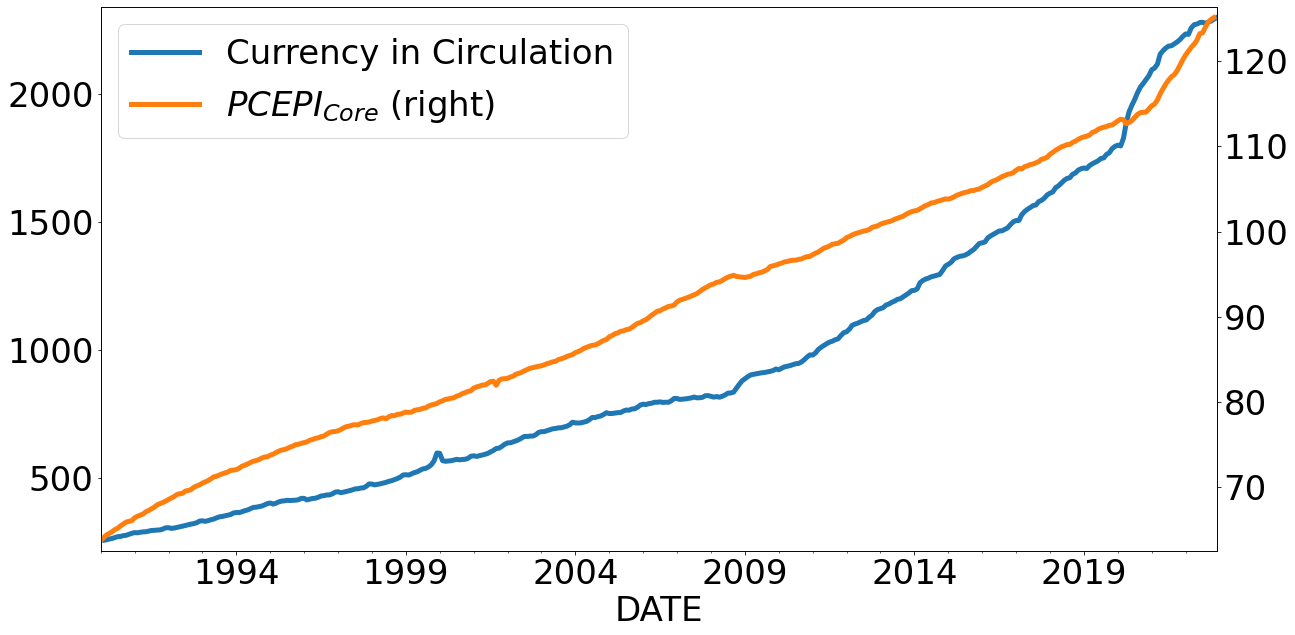

In [14]:
fig,ax = plt.subplots(figsize=(20,10))
df[["Currency in Circulation", "$PCEPI_{Core}$"]].plot.line(linewidth = 5,
                                                          ax = ax,
                                                         secondary_y = "$PCEPI_{Core}$")

# df.keys()

In [15]:
annual_rate["$CPI$"].loc["2008":]

DATE
2008-01-31    4.280294
2008-02-29    4.026555
2008-03-31    3.981456
2008-04-30    3.936890
2008-05-31    4.175543
                ...   
2022-08-31    8.262693
2022-09-30    8.201670
2022-10-31    7.745427
2022-11-30    7.110323
2022-12-31    6.454401
Freq: M, Name: $CPI$, Length: 180, dtype: float64

In [16]:

data_dict = {
             
            "$CPI$":"CPIAUCNS",             
             "$CPI_{Core}$":"CPILFESL",
            "$PCEPI_{Core}$":"PCEPILFE",
            "$PCEPI$": "PCEPI",
            }
freq = "M"
start = datetime.datetime(1990, 1, 1)
# end = datetime.datetime(1985, 12, 31)
end =datetime.datetime.today()

df = gather_data(data_dict, start, 
          end = end, freq = freq)

In [17]:
annual_rate = df.pct_change(12).mul(100)
monthly_rate = ((df.pct_change(1)).add(1)).pow(12).sub(1).mul(100)

C:\Users\JLCat\AppData\Local\Temp\ipykernel_22956\233663556.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(str(y) + "%" for y in ax.get_yticks())


Text(0.5, 0, '')

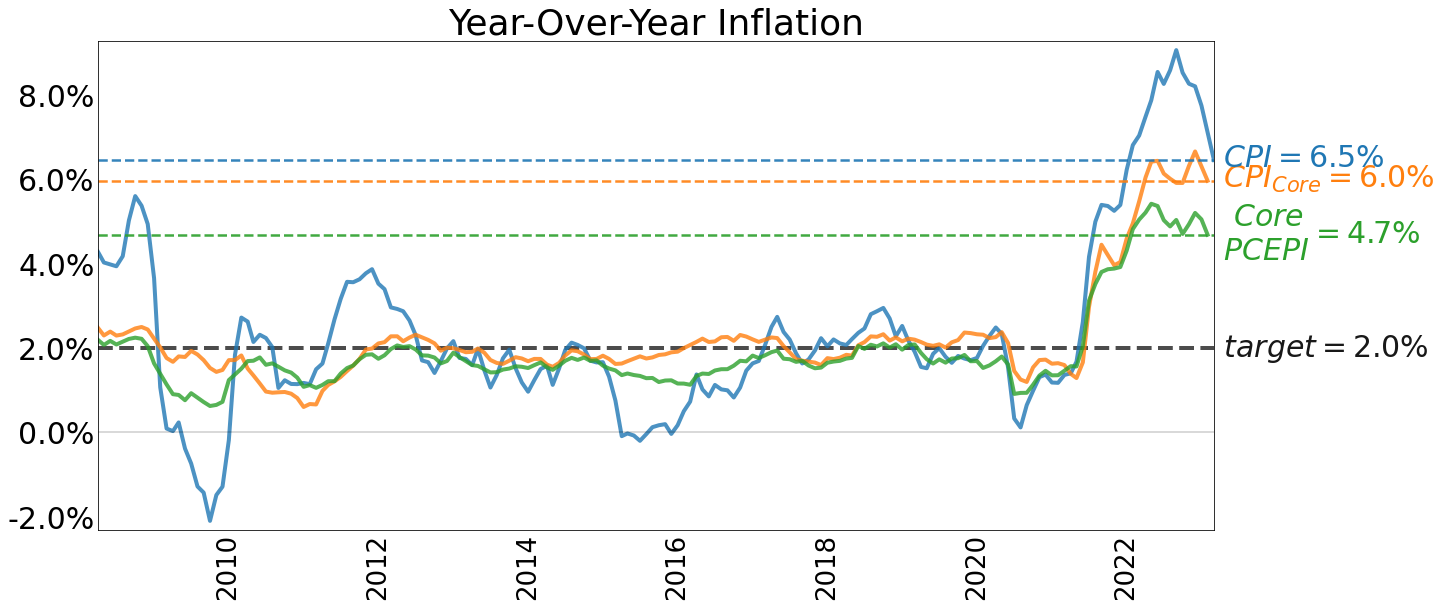

In [18]:
plt.rcParams['axes.ymargin'] = 0.02
plt.rcParams['axes.xmargin'] = 0.00

plt.rcParams.update({'font.size': 30})
plot_keys = ["$CPI$", 
             "$CPI_{Core}$",
             "$PCEPI_{Core}$",
            ]            
#             "$\pi_{PPI_{Final Demand}}$"]
plot_df = annual_rate[plot_keys].loc["2008":]#.dropna()
dates = list(plot_df.index)

fig,ax = plt.subplots(figsize=(20,10))
ax.axhline(2, ls = "--", linewidth = 4, color = "k", alpha = .7)
plot_df[plot_keys[0]].plot(ax = ax, linewidth = 4, legend = False, alpha = .8)
plot_df[plot_keys[1:]].iloc[:-1].plot(ax = ax, linewidth = 4, color = ["C1", "C2"], legend = False, alpha = .8)


ax.axhline(0, ls = "-", color = "k", alpha = .2)

ax.axhline(plot_df[plot_keys[0]].iloc[-1], ls = "--", linewidth = 2.5, color = "C" + str(0), alpha = .9)
ax.axhline(plot_df[plot_keys[1]].iloc[-2], ls = "--", linewidth = 2.5, color = "C" + str(1), alpha = .9)
ax.axhline(plot_df[plot_keys[2]].iloc[-2], ls = "--", linewidth = 2.5, color = "C" + str(2), alpha = .9)

# ax.axhline(5, ls = "--", color = "k", alpha = .5)
ax.set_yticklabels(str(y) + "%" for y in ax.get_yticks())
plt.xticks(rotation=90, fontsize =26)
ax.tick_params('both', length=0, which='both')
# ax.text("2009-10",3 ,  plot_keys[0], color = "C0", alpha = 1)
# ax.text("2015-08",2.5 ,  plot_keys[1], color = "C1", alpha = 1)
ax.text(dates[-1], 2, " " + "$target=2.0\%$", color = "k", alpha = .9, 
        ha = "left", va = "center")
pce_core_today =  plot_df[plot_keys[2]].round(1).iloc[-2]
cpi_core_today = plot_df[plot_keys[1]].round(1).iloc[-2]
ppi_today = plot_df[plot_keys[0]].round(1).iloc[-1]

ax.text(dates[-1],pce_core_today , "  $Core$\n $PCEPI$", color = "C2", alpha = 1, 
        ha = "left", va = "center")
ax.text(dates[-1],pce_core_today , "          $=" + str(pce_core_today) +"\%$", color = "C2", alpha = 1, 
        ha = "left", va = "center")
ax.text(dates[-1],cpi_core_today , " " + plot_keys[1] + "$=" + str(cpi_core_today) +"\%$", color = "C1", alpha = 1, 
        ha = "left", va = "center")
ax.text(dates[-1], ppi_today, " " + "$CPI=" + str(ppi_today) +"\%$", color = "C0", alpha = 1,
        ha = "left", va = "center")



ax.set_title("Year-Over-Year Inflation")
plt.xticks(rotation = 90)
ax.set_xlabel("")
# plot_lines(plot_df, linewidth = 5)

#plot_df.to_csv("inflationData.csv")

In [19]:
plot_df

,$CPI$,$CPI_{Core}$,$PCEPI_{Core}$
DATE,,,
2008-01-31,4.280294,2.478907,2.193131
2008-02-29,4.026555,2.297081,2.072026
2008-03-31,3.981456,2.388524,2.168811
2008-04-30,3.936890,2.294669,2.083266
2008-05-31,4.175543,2.322216,2.149081
...,...,...,...
2022-08-31,8.262693,6.317086,4.934052
2022-09-30,8.201670,6.657810,5.201526
2022-10-31,7.745427,6.306597,5.048390


C:\Users\JLCat\AppData\Local\Temp\ipykernel_22956\811755934.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(val)) + "%" for val in ax.get_yticks()], fontsize = 26)


,$CPI$,$CPI_{Core}$
$CPI$,1.000000,0.567097
$CPI_{Core}$,0.567097,1.000000


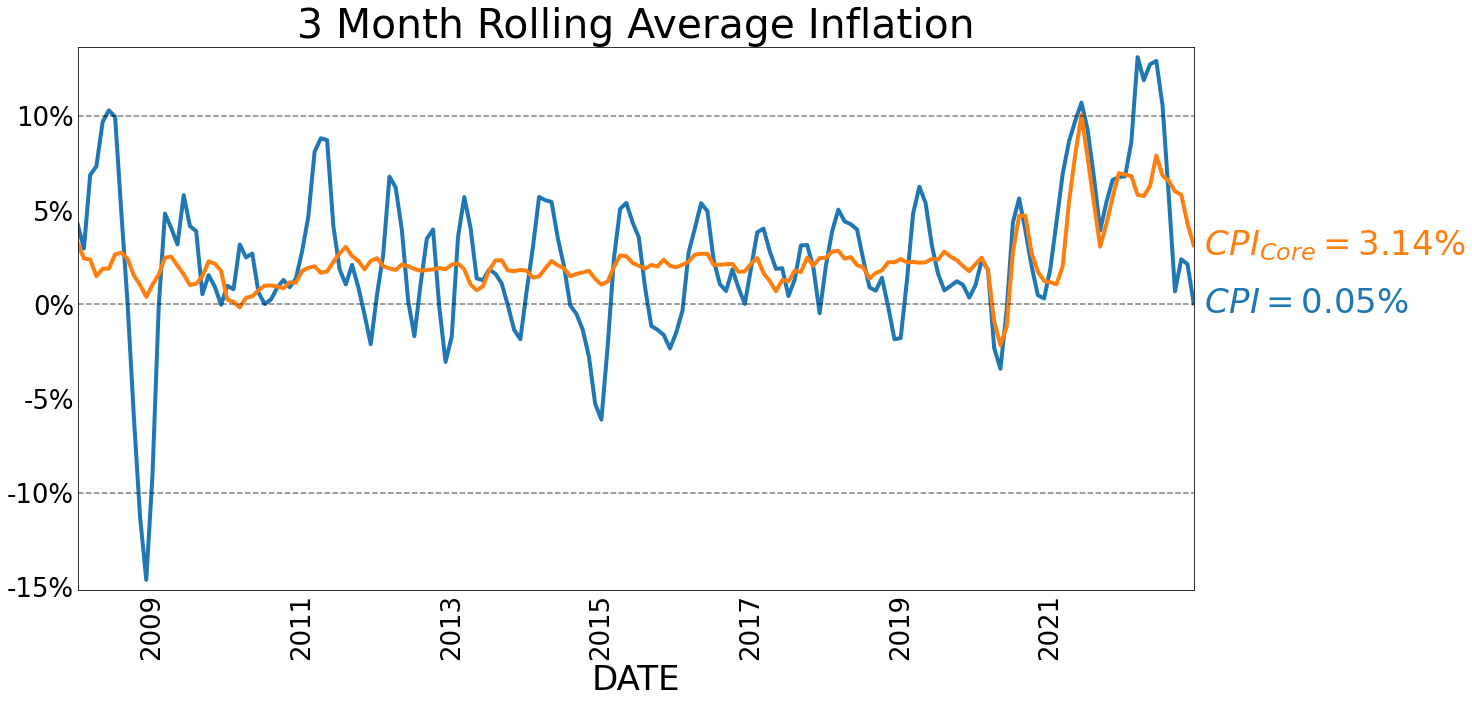

In [20]:
plt.rcParams.update({'font.size': 34})

months = 3
plot_df = monthly_rate[plot_keys[:-1]].rolling(months).mean().loc["2008":].dropna()[plot_keys[:-1]]
fig,ax = plt.subplots(figsize=(20,10))
plot_df.plot(ax = ax, linewidth = 4, legend = False)
ax.axhline(0, ls = "--", color = "k", alpha = .5)
ax.axhline(-10, ls = "--", color = "k", alpha = .5)
ax.axhline(10, ls = "--", color = "k", alpha = .5)
ax.set_yticklabels([str(int(val)) + "%" for val in ax.get_yticks()], fontsize = 26)
plt.xticks(rotation=90, fontsize =26)
ax.tick_params('both', length=0, which='both')

ax.text(dates[-1],plot_df[plot_keys[1]][-1] , " " + plot_keys[1] + "$=" + str(plot_df[plot_keys[1]].round(2)[-1]) +"\%$", color = "C1", alpha = 1, 
        ha = "left", va = "center")
ax.text(dates[-1],plot_df[plot_keys[0]][-1] , " " + plot_keys[0] + "$=" + str(plot_df[plot_keys[0]].round(2)[-1]) +"\%$", color = "C0", alpha = 1, 
        ha = "left", va = "center")
ax.set_title(str(months) + " Month Rolling Average Inflation")
plot_df.corr()

In [21]:
monthly_rate

,$CPI$,$CPI_{Core}$,$PCEPI_{Core}$,$PCEPI$
DATE,,,,
1990-01-31,NaN,NaN,NaN,NaN
1990-02-28,5.800203,5.588656,5.998168,5.419193
1990-03-31,6.763531,7.479123,5.909054,4.608154
1990-04-30,1.880823,4.588129,3.641316,2.546624
1990-05-31,2.828892,3.641489,3.726434,2.737630
...,...,...,...,...
2022-08-31,-0.424451,7.023664,6.809184,3.266795
2022-09-30,2.611692,7.133372,5.717367,4.210788
2022-10-31,4.977879,3.307665,3.185041,4.568026


In [22]:
plot_df

,$CPI$,$CPI_{Core}$
DATE,,
2008-01-31,4.231157,3.233823
2008-02-29,2.956519,2.433161
2008-03-31,6.861335,2.375517
2008-04-30,7.326329,1.488353
2008-05-31,9.674771,1.880401
...,...,...
2022-08-31,5.740432,6.552947
2022-09-30,0.681863,5.992330
2022-10-31,2.388373,5.821567
